In [ ]:
import pandas as pd
import functions as func
import xgboost as xgb
from patsy import dmatrices, dmatrix
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae



In [2]:
# PARITY
api_url = 'https://gamesheetstats.com/api/useScoredGames/getSeasonScores/6775?filter[limit]=10000'
df_parity_1 = func.parse_rest_api_to_pandas(api_url)

df_parity_1 = df_parity_1[['date','game.number','game.type','game.gameId','game.homeTeam.id','game.homeTeam.name','game.homeTeam.division','game.visitorTeam.id','game.visitorTeam.name','game.visitorTeam.division','game.finalScore.homeGoals','game.finalScore.visitorGoals']]
df_parity_1 = df_parity_1.rename(columns={'game.number':'game_number','game.type':'game_type','game.gameId':'game_id','game.homeTeam.id':'hometeam_id','game.homeTeam.name':'hometeam_name','game.homeTeam.division':'hometeam_division','game.visitorTeam.id':'visitorteam_id','game.visitorTeam.name':'visitorteam_name','game.visitorTeam.division':'visitorteam_division','game.finalScore.homeGoals':'homegoals','game.finalScore.visitorGoals':'visitorgoals'})

# SEASON
api_url = 'https://gamesheetstats.com/api/useScoredGames/getSeasonScores/6642?filter[limit]=10000'

df_season_1 = func.parse_rest_api_to_pandas(api_url)

df_season_1 = df_season_1[['date','game.number','game.type','game.gameId','game.homeTeam.id','game.homeTeam.name','game.homeTeam.division','game.visitorTeam.id','game.visitorTeam.name','game.visitorTeam.division','game.finalScore.homeGoals','game.finalScore.visitorGoals']]
df_season_1 = df_season_1.rename(columns={'game.number':'game_number','game.type':'game_type','game.gameId':'game_id','game.homeTeam.id':'hometeam_id','game.homeTeam.name':'hometeam_name','game.homeTeam.division':'hometeam_division','game.visitorTeam.id':'visitorteam_id','game.visitorTeam.name':'visitorteam_name','game.visitorTeam.division':'visitorteam_division','game.finalScore.homeGoals':'homegoals','game.finalScore.visitorGoals':'visitorgoals'})

In [11]:
# BUILD OUT PARITY DATASET
df_parity_2 = df_parity_1.rename(columns={'hometeam_id':'visitorteam_id','hometeam_name':'visitorteam_name','hometeam_division':'visitorteam_division','visitorteam_id':'hometeam_id','visitorteam_name':'hometeam_name','visitorteam_division':'hometeam_division','homegoals':'visitorgoals','visitorgoals':'homegoals'})
df_parity_1['keep']='1'
df_parity_2['keep']='0'

df_parity = pd.concat([df_parity_1, df_parity_2], ignore_index=True, axis=0, join="inner")
del df_parity_2

df_parity['goal_diff'] = df_parity['homegoals'] - df_parity['visitorgoals']


# SET COLUMN TYPES
for col in df_parity.columns.to_list():
    if col in ('homegoals','visitorgoals','goal_diff','days'):
        df_parity[col] = pd.to_numeric(df_parity[col])
    elif col =='date':
        df_parity[col] = pd.to_datetime(df_parity[col])
    else:
        df_parity[col] = df_parity[col].astype('category')

# set number of days into hockey season
mn_dt = df_parity['date'].min()
df_parity['days'] = (df_parity['date'] - mn_dt).dt.days

df_parity = df_parity.dropna().reset_index()

In [12]:
# BUILD OUT SEASON DATASET
df_season_2 = df_season_1.rename(columns={'hometeam_id':'visitorteam_id','hometeam_name':'visitorteam_name','hometeam_division':'visitorteam_division','visitorteam_id':'hometeam_id','visitorteam_name':'hometeam_name','visitorteam_division':'hometeam_division','homegoals':'visitorgoals','visitorgoals':'homegoals'})
df_season_1['keep']='1'
df_season_2['keep']='0'

df_season = pd.concat([df_season_1, df_season_2], ignore_index=True, axis=0, join="inner")
del df_season_2

df_season['goal_diff'] = df_season['homegoals'] - df_season['visitorgoals']


# SET COLUMN TYPES
for col in df_season.columns.to_list():
    if col in ('homegoals','visitorgoals','goal_diff','days'):
        df_season[col] = pd.to_numeric(df_season[col])
    elif col =='date':
        df_season[col] = pd.to_datetime(df_season[col])
    else:
        df_season[col] = df_season[col].astype('category')

# set number of days into hockey season
mn_dt = df_season['date'].min()
df_season['days'] = (df_season['date'] - mn_dt).dt.days

df_season = df_season.dropna().reset_index()

TRAIN GLM ON PARITY ROUNDS

In [48]:
# GLM: Poisson (Home Goals)
glm_forumula = (''' homegoals ~ hometeam_name + visitorteam_name ''')

y, X = dmatrices(glm_forumula, data=df_parity, return_type='dataframe')


glm_P = PoissonRegressor( alpha=0, solver='lbfgs', max_iter=10000, verbose=0, tol=0.05)
glm_P.fit(X, y['homegoals'])

pred = pd.DataFrame(glm_P.predict(X), columns=['pred_home'])
out = pd.concat([df_parity, pred], axis=1)

# Apply visitor team predictions
out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

# Calculate goal differences and total points
out_full['pred_diff'] = out_full['pred_home'] - out_full['pred_visitor']
out_full['home_points'] = np.where(out_full['homegoals'] > out_full['visitorgoals'], 2, 
                                    np.where(out_full['homegoals'] == out_full['visitorgoals'], 1, 0))
out_full['pred_points'] = np.where(out_full['pred_home'] > out_full['pred_visitor'], 2, 
                                    np.where(out_full['pred_home'] == out_full['pred_visitor'], 1, 0))


print('R2: ', round(r2_score(out_full['goal_diff'], out_full['pred_diff']), 4))
print('MAE: ', round(mae(out_full['goal_diff'], out_full['pred_diff']), 4))

R2:  0.8512
MAE:  1.2664


In [5]:
# out_full.groupby('hometeam_division', observed=True)['hometeam_name'].nunique()

GOAL PREDICTION STATS
R2:  0.858
MAE:  1.4946

POINT PREDICTION STATS
R2:  0.9622
MAE:  0.1818


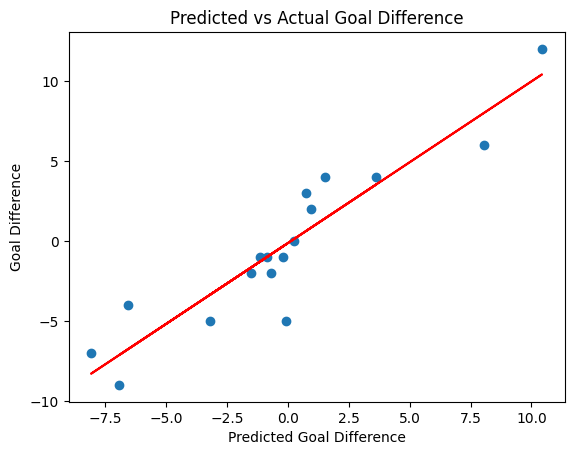

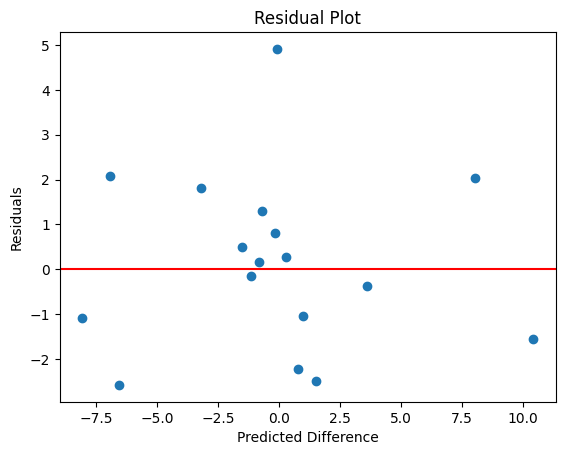

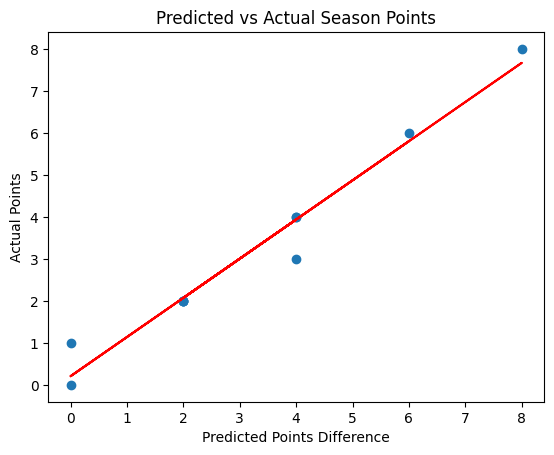

In [49]:
# CHARTS
# out_filter = out_full
out_filter = out_full[(out_full['hometeam_division']=='10U Tier 4')]

plt_1, r2_1, mae_1, plt_2, plt_3, r2_3, mae_3 = func.model_charts(out_filter)

print('GOAL PREDICTION STATS')
print('R2: ', r2_1)
print('MAE: ', mae_1)
print()

print('POINT PREDICTION STATS')
print('R2: ', r2_3)
print('MAE: ', mae_3)

APPLY PARITY PREDICTIONS TO REGULAR SEASON

In [81]:
X_s_init = dmatrix(glm_forumula.replace("homegoals ~", ""), data=df_season, return_type='dataframe')

X_s = pd.concat([X.head(0), X_s_init])
X_s = X_s[X.columns]
X_s = X_s.fillna(0)


pred_s = pd.DataFrame(glm_P.predict(X_s), columns=['pred_home'])
out = pd.concat([df_season, pred_s], axis=1)

# Apply visitor team predictions
out2 = out[['game_id', 'visitorteam_id', 'pred_home']].rename(columns={'visitorteam_id': 'hometeam_id', 'pred_home': 'pred_visitor'})
out_full_s = pd.merge(out, out2, on=['game_id', 'hometeam_id'])
del out, out2

# Only keep teams/divisions that are in both datasets
out_full_s = pd.merge(out_full_s, df_parity[['hometeam_name','hometeam_division']].drop_duplicates(), on=['hometeam_name','hometeam_division'], how='inner')
out_full_s = pd.merge(out_full_s, df_parity[['visitorteam_name','visitorteam_division']].drop_duplicates(), on=['visitorteam_name','visitorteam_division'], how='inner')


# Calculate goal differences and total points
out_full_s['pred_diff'] = out_full_s['pred_home'] - out_full_s['pred_visitor']
out_full_s['home_points'] = np.where(out_full_s['homegoals'] > out_full_s['visitorgoals'], 2, 
                                    np.where(out_full_s['homegoals'] == out_full_s['visitorgoals'], 1, 0))
out_full_s['pred_points'] = np.where(out_full_s['pred_home'] > out_full_s['pred_visitor'], 2, 
                                    np.where(out_full_s['pred_home'] == out_full_s['pred_visitor'], 1, 0))


print('R2: ', round(r2_score(out_full_s['goal_diff'], out_full_s['pred_diff']), 4))
print('MAE: ', round(mae(out_full_s['goal_diff'], out_full_s['pred_diff']), 4))

R2:  0.1754
MAE:  3.462


GOAL PREDICTION STATS
R2:  0.8512
MAE:  1.2664

POINT PREDICTION STATS
R2:  0.7693
MAE:  0.6582


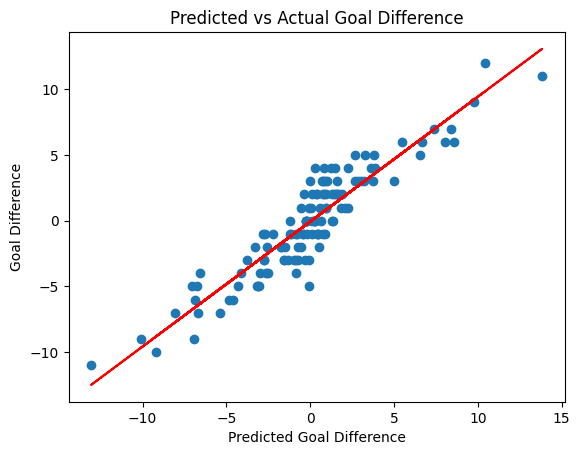

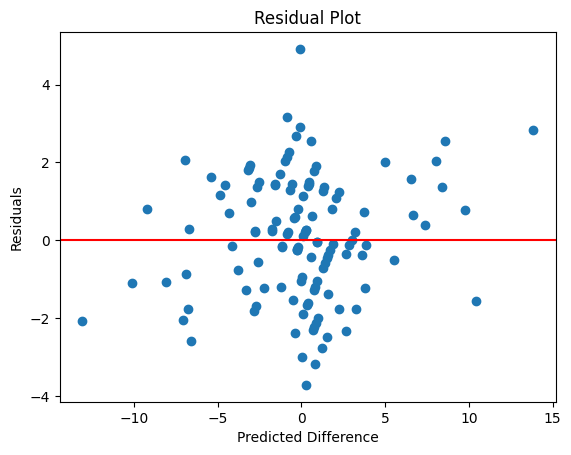

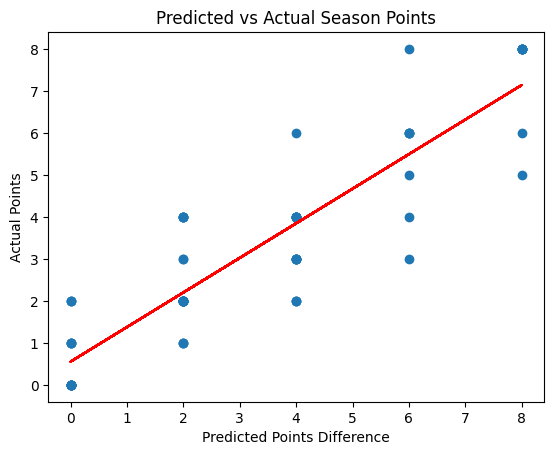

In [90]:
# CHARTS
out_filter = out_full
# out_filter = out_full_s[(out_full_s['hometeam_division']=='10U Tier 4')]

plt_1, r2_1, mae_1, plt_2, plt_3, r2_3, mae_3 = func.model_charts(out_filter)

print('GOAL PREDICTION STATS')
print('R2: ', r2_1)
print('MAE: ', mae_1)
print()

print('POINT PREDICTION STATS')
print('R2: ', r2_3)
print('MAE: ', mae_3)

In [88]:
out_filter = out_full_s.groupby(['hometeam_division','hometeam_name'], observed=True).agg({'home_points':'sum', 'pred_points':'sum'}).reset_index()
out_filter['diff'] = out_filter['home_points'] - out_filter['pred_points']
out_filter = out_filter.sort_values(by=['hometeam_division', 'home_points'], ascending=[True, False])
out_filter

,hometeam_division,hometeam_name,home_points,pred_points,diff
1,10U Tier 3,Manchester 10U Minor I - King,12,12,0
0,10U Tier 3,Berlin 10U Paiva,7,0,7
3,10U Tier 3,Upper Valley 10u Blue,4,4,0
2,10U Tier 3,NE Wolves 10U Premier,1,8,-7
9,10U Tier 4,Rochester Squirt 1,20,20,0
8,10U Tier 4,NH East 10U 1,14,12,2
7,10U Tier 4,Manchester 10U Major II - Greenwood,12,8,4
5,10U Tier 4,Granite State Wild Squirt Minor 9U,5,0,5
6,10U Tier 4,Keene 10U White,5,4,1
4,10U Tier 4,Back Bay 10U Alcaraz,4,16,-12


C:\Users\baref\AppData\Local\Temp\ipykernel_30800\3531834046.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  out_chart = out_filter[(out_full_s['keep'] == '1')]


Text(0.5, 1.0, 'Predicted vs Actual Goal Difference')

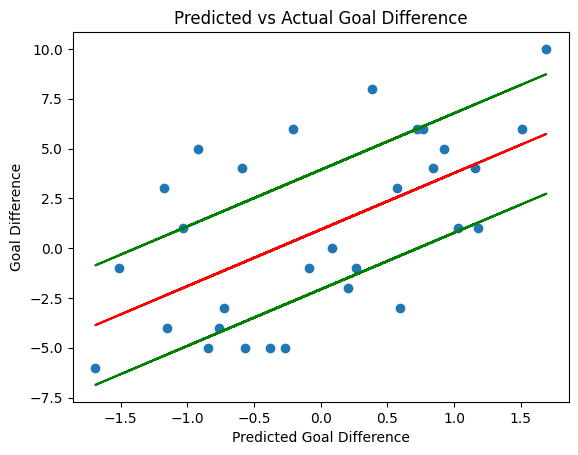

In [96]:
out_filter = out_full_s[(out_full_s['hometeam_division']=='10U Tier 4')]
out_chart = out_filter[(out_full_s['keep'] == '1')]
slope, intercept, rvalue, pvalue, stderr = stats.linregress(out_chart['pred_diff'], out_chart['goal_diff'])

fig1, ax1 = plt.subplots()
ax1.scatter(out_chart['pred_diff'], out_chart['goal_diff'])
ax1.plot(out_chart['pred_diff'], intercept + slope*out_chart['pred_diff'], 'r')
ax1.plot(out_chart['pred_diff'], intercept+3 + slope*out_chart['pred_diff'], 'g')
ax1.plot(out_chart['pred_diff'], intercept-3 + slope*out_chart['pred_diff'], 'g')
ax1.set_xlabel('Predicted Goal Difference')
ax1.set_ylabel('Goal Difference')
ax1.set_title('Predicted vs Actual Goal Difference')